<a href="https://colab.research.google.com/github/AloraTab/aat2000/blob/main/dissy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
%pip install pandas==1.5.3
%pip install tensorflow-addons==0.19.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 87.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.4
    Uninstalling pandas-1.4.4:
      Successfully uninstalled pandas-1.4.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.5 MB/s eta 0:00:00


In [2]:
from tensorflow import keras
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import Attention
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers.schedules import ExponentialDecay, CosineDecayRestarts
from keras.callbacks import Callback
from keras import backend as K

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math

## Imported Classes

In [3]:
# Cosine Annealing Scheduler
# https://github.com/4uiiurz1/keras-cosine-annealing/blob/master/cosine_annealing.py

class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [4]:
# LR Finder in Keras
# https://github.com/avanwyk/tensorflow-projects/tree/master/lr-finder

class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [5]:
# From https://gist.github.com/avanwyk/57724eb3cfff60a1451e4b422c73bfb7#file-lr_one_cycle-py
import logging

logging.getLogger('tensorflow').setLevel(logging.ERROR)

class CosineAnnealer:
    
    def __init__(self, start, end, steps):
        self.start = start
        self.end = end
        self.steps = steps
        self.n = 0
        
    def step(self):
        self.n += 1
        cos = np.cos(np.pi * (self.n / self.steps)) + 1
        return self.end + (self.start - self.end) / 2. * cos


class OneCycleScheduler(Callback):
    """ `Callback` that schedules the learning rate on a 1cycle policy as per Leslie Smith's paper(https://arxiv.org/pdf/1803.09820.pdf).
    If the model supports a momentum parameter, it will also be adapted by the schedule.
    The implementation adopts additional improvements as per the fastai library: https://docs.fast.ai/callbacks.one_cycle.html, where
    only two phases are used and the adaptation is done using cosine annealing.
    In phase 1 the LR increases from `lr_max / div_factor` to `lr_max` and momentum decreases from `mom_max` to `mom_min`.
    In the second phase the LR decreases from `lr_max` to `lr_max / (div_factor * 1e4)` and momemtum from `mom_max` to `mom_min`.
    By default the phases are not of equal length, with the phase 1 percentage controlled by the parameter `phase_1_pct`.
    """

    def __init__(self, lr_max, steps, mom_min=0.85, mom_max=0.95, phase_1_pct=0.3, div_factor=25.):
        super(OneCycleScheduler, self).__init__()
        lr_min = lr_max / div_factor
        final_lr = lr_max / (div_factor * 1e4)
        phase_1_steps = steps * phase_1_pct
        phase_2_steps = steps - phase_1_steps
        
        self.phase_1_steps = phase_1_steps
        self.phase_2_steps = phase_2_steps
        self.phase = 0
        self.step = 0
        
        self.phases = [[CosineAnnealer(lr_min, lr_max, phase_1_steps), CosineAnnealer(mom_max, mom_min, phase_1_steps)], 
                 [CosineAnnealer(lr_max, final_lr, phase_2_steps), CosineAnnealer(mom_min, mom_max, phase_2_steps)]]
        
        self.lrs = []
        self.moms = []

    def on_train_begin(self, logs=None):
        self.phase = 0
        self.step = 0

        self.set_lr(self.lr_schedule().start)
        self.set_momentum(self.mom_schedule().start)
        
    def on_train_batch_begin(self, batch, logs=None):
        self.lrs.append(self.get_lr())
        self.moms.append(self.get_momentum())

    def on_train_batch_end(self, batch, logs=None):
        self.step += 1
        if self.step >= self.phase_1_steps:
            self.phase = 1
            
        self.set_lr(self.lr_schedule().step())
        self.set_momentum(self.mom_schedule().step())
        
    def get_lr(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.lr)
        except AttributeError:
            return None
        
    def get_momentum(self):
        try:
            return tf.keras.backend.get_value(self.model.optimizer.momentum)
        except AttributeError:
            return None
        
    def set_lr(self, lr):
        try:
            tf.keras.backend.set_value(self.model.optimizer.lr, lr)
        except AttributeError:
            pass # ignore
        
    def set_momentum(self, mom):
        try:
            tf.keras.backend.set_value(self.model.optimizer.momentum, mom)
        except AttributeError:
            pass # ignore

    def lr_schedule(self):
        return self.phases[self.phase][0]
    
    def mom_schedule(self):
        return self.phases[self.phase][1]
    
    def plot(self):
        ax = plt.subplot(1, 2, 1)
        ax.plot(self.lrs)
        ax.set_title('Learning Rate')
        ax = plt.subplot(1, 2, 2)
        ax.plot(self.moms)
        ax.set_title('Momentum')

# Preparing Dataset

In [49]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [50]:
PATH = '/content/gdrive/MyDrive/Colab Notebooks/Dataset'
fileName = 'csi-dataset-20-7-5.pkl'
fullPath = os.path.join(PATH, fileName)
print(fullPath)

/content/gdrive/MyDrive/Colab Notebooks/Dataset/csi-dataset-20-7-5.pkl


In [51]:
df = pd.read_pickle(fullPath)

In [52]:
# df = df.sample(frac=1)
Y = df['Label'].values
X = df['Sample'].values
X = [[np.asarray(sample) for sample in i] for i in X]
X = np.asarray(X).astype('float32')

In [53]:
X.shape

(6642, 256, 180)

In [54]:
# unique, counts = np.unique(Y_test, return_counts=True)
# print(np.asarray((unique, counts)).T)

In [55]:
# unique, counts = np.unique(Y_train, return_counts=True)
# print(np.asarray((unique, counts)).T)

In [56]:
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
vectorized_y = np_utils.to_categorical(encoded_Y)

In [57]:
classes = encoder.classes_
print(classes)

['I1' 'I11' 'I13' 'I3' 'I5' 'I7' 'I9']


In [58]:
X_train, X_test, Y_train, Y_test = train_test_split(X,vectorized_y, test_size=0.3, random_state=40)

In [59]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],X_train.shape[2],1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],X_test.shape[2],1))

X_train = tf.convert_to_tensor(X_train)
Y_train = tf.convert_to_tensor(Y_train)

# Building Model

### Custom Components

In [17]:
# Residual Connections
# https://stackoverflow.com/questions/64792460/how-to-code-a-residual-block-using-two-layers-of-a-basic-cnn-algorithm-built-wit

def resblock(x, kernelsize, filters):
    fx = keras.layers.Conv2D(filters, kernelsize, activation='relu', padding='same')(x)
    fx = keras.layers.BatchNormalization()(fx)
    fx = keras.layers.Conv2D(filters, kernelsize, padding='same')(fx)
    out = keras.layers.Add()([x,fx])
    out = keras.layers.ReLU()(out)
    out = keras.layers.BatchNormalization()(out)
    return out

In [18]:
# Mish Activation
def mish(inputs):
    x = tf.nn.softplus(inputs)
    x = tf.nn.tanh(x)
    x = tf.multiply(x,inputs)
    return x

In [19]:
# Ranger Optimizer
# www.kaggle.com/code/yazanmajzob/ranger-optimizeranvas.com

import tensorflow_addons as tfa

def Ranger(sync_period=6,
           slow_step_size=0.5,
           learning_rate=0.001,
           beta_1=0.9,
           beta_2=0.999,
           epsilon=1e-7,
           weight_decay=0.,
           amsgrad=False,
           sma_threshold=5.0,
           total_steps=0,
           warmup_proportion=0.1,
           min_lr=0.,
           name="Ranger"):
    inner = tfa.optimizers.RectifiedAdam(learning_rate, beta_1, beta_2, epsilon, weight_decay, amsgrad, sma_threshold, total_steps, warmup_proportion, min_lr, name)
    optim = tfa.optimizers.Lookahead(inner, sync_period, slow_step_size, name)
    return optim

### Model Building

In [29]:
def csiTime_block(input_layer):
    # layer_1 = Conv2D(10, (1,1), padding='same', activation='relu')(input_layer)
    # layer_1 = Conv2D(16, (10,10), padding='same', activation='relu')(input_layer)
    layer_1 = SeparableConv2D(32, (10,10), padding='same', activation='relu')(input_layer)

    # layer_2 = Conv2D(10, (1,1), padding='same', activation='relu')(input_layer)
    # layer_2 = Conv2D(16, (20,20), padding='same', activation='relu')(input_layer)
    layer_2 = SeparableConv2D(32, (20,20), padding='same', activation='relu')(input_layer)

    # layer_3 = Conv2D(10, (1,1), padding='same')(input_layer)
    # layer_3 = Conv2D(16, (40,40), padding='same', activation='relu')(input_layer)
    layer_3 = SeparableConv2D(32, (40,40), padding='same', activation='relu')(input_layer)

    layer_4 = keras.layers.MaxPooling2D(pool_size=(1,1))(input_layer)

    layer_5 = keras.layers.concatenate([layer_1, layer_2, layer_3, layer_4], axis = 3)

    layer_6 = keras.layers.BatchNormalization()(layer_5)
    layer_7 = keras.layers.Attention()([layer_6, layer_6])
    # layer_4 = SeqSelfAttention(attention_activation='sigmoid')([layer_4, layer_4])
    # flatten = keras.layers.Flatten()(attn)
    output_layer = keras.layers.Dense(7, activation=mish)(layer_7)
    
    return output_layer

In [30]:
from tensorflow.python.ops.nn_ops import softmax

def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape, dtype='float32')

    fir = csiTime_block(input_layer)
    sec = csiTime_block(fir)
    res1 = resblock(sec, (3,3), 7)
    thi = csiTime_block(res1)
    # fou = csiTime_block(thi)
    # fif = csiTime_block(fou)
    # res2 = resblock(fif, (3,3), 7)
    # six = csiTime_block(res2)

    gap = keras.layers.GlobalAveragePooling2D()(thi)
    dropout = keras.layers.Dropout(.2)(gap)
    # layer_4 = keras.layers.Flatten()(layer_4)
    output_layer = keras.layers.Dense(7, activation=softmax)(gap) #Need to change to num of classes
    
    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])
# keras.utils.plot_model(model, show_shapes=True)

In [60]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 180, 1  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d_9 (SeparableC  (None, 256, 180, 32  164        ['input_2[0][0]']                
 onv2D)                         )                                                                 
                                                                                                  
 separable_conv2d_10 (Separable  (None, 256, 180, 32  464        ['input_2[0][0]']                
 Conv2D)                        )                                                           

In [63]:
epochs = 20
batch_size = 48

# lr_finder = LRFinder()
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=100, decay_rate=0.96,
    staircase=True)

# lr_schedule = CosineDecayRestarts(initial_learning_rate=0.001,first_decay_steps=100)
# lr_schedule = OneCycleScheduler(0.01, 1000)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "p5.h5", save_best_only=True, monitor="val_loss"
    ),
    # lr_finder
    # keras.callbacks.ReduceLROnPlateau(
    #     monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    # ),
    # CosineAnnealingScheduler(T_max=100, eta_max=1e-2, eta_min=1e-4),
    # keras.callbacks.EarlyStopping(monitor="val_loss", patience=0, verbose=1),
]
model.compile(
    optimizer=Ranger(learning_rate = lr_schedule),
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)
history = model.fit(
    X_train,
    Y_train,
    # steps_per_epoch = int(trainX_size/batch_size),
    # validation_steps = int(trainY_size/batch_size),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
    
)

Epoch 1/20
78/78 [==============================] - 62s 611ms/step - loss: 0.7675 - categorical_accuracy: 0.6779 - val_loss: 0.7624 - val_categorical_accuracy: 0.6720
Epoch 2/20
78/78 [==============================] - 47s 605ms/step - loss: 0.7561 - categorical_accuracy: 0.6838 - val_loss: 0.7562 - val_categorical_accuracy: 0.6817
Epoch 3/20
78/78 [==============================] - 47s 603ms/step - loss: 0.7495 - categorical_accuracy: 0.6916 - val_loss: 0.8434 - val_categorical_accuracy: 0.6441
Epoch 4/20
78/78 [==============================] - 47s 602ms/step - loss: 0.7312 - categorical_accuracy: 0.7023 - val_loss: 0.7695 - val_categorical_accuracy: 0.6989
Epoch 5/20
78/78 [==============================] - 47s 604ms/step - loss: 0.7289 - categorical_accuracy: 0.6884 - val_loss: 0.7371 - val_categorical_accuracy: 0.6989
Epoch 6/20
78/78 [==============================] - 47s 605ms/step - loss: 0.7187 - categorical_accuracy: 0.7015 - val_loss: 0.7155 - val_categorical_accuracy: 0.711

# Evaluation

In [64]:
# model = keras.models.load_model("sa-mish-adam-150.h5")

test_loss, test_acc = model.evaluate(X_test[:,:,:], Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

63/63 [==============================] - 8s 119ms/step - loss: 0.6754 - categorical_accuracy: 0.7205
Test accuracy 0.7205218076705933
Test loss 0.6754424571990967


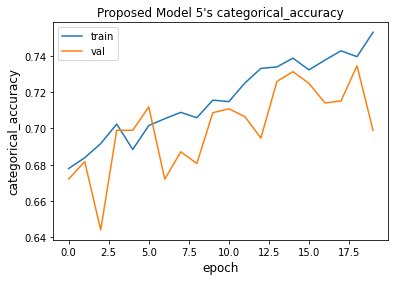

In [65]:
metric = "categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Proposed Model 5's " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [66]:
#Confusion Matrix and Classification Report

y_pred=model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
Y_test=np.argmax(Y_test, axis=1)
cm = confusion_matrix(Y_test, y_pred)
print(cm)

print('Classification Report')
print(classification_report(Y_test, y_pred, target_names=classes))

63/63 [==============================] - 8s 117ms/step
[[193   5   2   1  25   0   0]
 [ 17 131   4   0  22  15   0]
 [  8   2 574   9   7   1  88]
 [  4   0  12 157   3   8  56]
 [ 25  30   2   3  82  36   0]
 [ 16  23   3   1  62  71   0]
 [  3   0  13  49   1   1 228]]
Classification Report
              precision    recall  f1-score   support

          I1       0.73      0.85      0.78       226
         I11       0.69      0.69      0.69       189
         I13       0.94      0.83      0.88       689
          I3       0.71      0.65      0.68       240
          I5       0.41      0.46      0.43       178
          I7       0.54      0.40      0.46       176
          I9       0.61      0.77      0.68       295

    accuracy                           0.72      1993
   macro avg       0.66      0.67      0.66      1993
weighted avg       0.73      0.72      0.72      1993



In [67]:
%%time 

model.predict(X_test[:10])

1/1 [==============================] - 0s 60ms/step
CPU times: user 67.8 ms, sys: 4.62 ms, total: 72.4 ms
Wall time: 96.5 ms


array([[6.74066250e-04, 3.48512185e-06, 1.35263547e-01, 6.87520653e-02,
        4.46116428e-05, 5.40949850e-06, 7.95256793e-01],
       [2.82189436e-03, 6.35956079e-02, 1.81027872e-06, 1.00357400e-04,
        4.04797882e-01, 5.28540850e-01, 1.41604643e-04],
       [1.52976185e-01, 1.62147090e-01, 1.46645971e-03, 2.36842921e-03,
        4.10447747e-01, 2.68204659e-01, 2.38941587e-03],
       [3.63796055e-02, 8.93095374e-01, 7.47038925e-04, 4.36695962e-04,
        3.66294160e-02, 3.25609855e-02, 1.50867520e-04],
       [1.74939722e-01, 1.41219512e-01, 2.11012930e-01, 3.78373936e-02,
        2.31927037e-01, 1.90685645e-01, 1.23777455e-02],
       [1.20237537e-01, 4.60247211e-02, 7.09247828e-01, 1.20069133e-03,
        8.16780552e-02, 4.14037518e-02, 2.07439953e-04],
       [2.38600709e-02, 1.93261784e-02, 1.21245463e-03, 3.98471504e-01,
        1.61255464e-01, 1.44823864e-01, 2.51050442e-01],
       [2.05436096e-01, 9.24103614e-03, 1.52622943e-05, 4.39989599e-05,
        6.01700902e-01, 1